# Human Emotion Recognition

### Personal Project

Nina Cardenas

## 0. Initialization and setup

In [105]:
!pip install plotly
!pip install matplotlib
!pip install tensorflow-macos
!pip install tensorflow-metal
!pip install -U scikit-learn
!pip install scipy

In [106]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as ks
import tensorflow as tf
import sklearn.model_selection as model_selection
import keras
import scipy
from keras.preprocessing.image import ImageDataGenerator

## 1. Data Collection and Analysis

In [107]:
raw_df = pd.read_csv("fer2013.csv")
labels = ["Anger", "Disgust", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]
labels_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

In [108]:
raw_df.shape

(35887, 3)

In [109]:
raw_df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


### 1.1 Analyzing class distribution

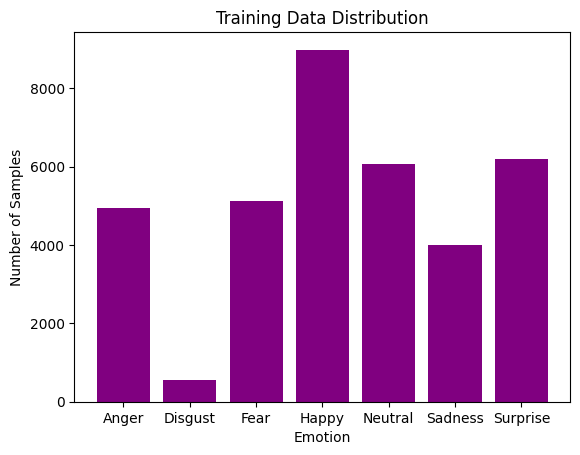

In [110]:
plt.title("Training Data Distribution")
plt.bar(labels, [list(raw_df['emotion']).count(i) for i in np.unique(raw_df['emotion'])], color="purple")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")

plt.show()

### 1.2 Class imbalance

In [111]:
occ = np.bincount(raw_df['emotion'])
total = np.sum(occ)
disgust = np.amin(occ)
happy = np.amax(occ)
print('Total classes: {}\nTotal samples: {}\nDisgust: {} ({:.2f}% of total)\nHappy: {} ({:.2f}% of total)\n'.format(len(occ),
    total, disgust, 100 * disgust / total,happy,100*happy/total))

Total classes: 7
Total samples: 35887
Disgust: 547 (1.52% of total)
Happy: 8989 (25.05% of total)



## 2. Preprocessing

In [112]:
# shuffle dataset
df = raw_df.sample(frac=1)#,random_state=1)
df

,emotion,pixels,Usage
8603,6,15 8 2 5 6 6 6 5 7 10 8 9 17 15 3 19 18 47 60 ...,Training
19289,0,231 237 238 234 237 239 238 184 95 59 13 17 25...,Training
25211,4,32 37 37 33 35 36 33 44 60 85 140 211 235 246 ...,Training
7261,0,117 112 109 85 61 44 49 26 104 220 225 228 231...,Training
22728,4,126 124 127 127 90 124 181 184 192 198 201 203...,Training
...,...,...,...
23385,6,22 22 28 22 18 26 49 59 73 82 96 111 121 132 1...,Training
7854,0,136 135 131 137 119 111 141 156 139 116 101 10...,Training
23612,3,13 10 7 8 11 12 12 11 9 7 6 5 5 5 4 4 4 6 8 8 ...,Training
27182,3,163 145 119 81 55 41 43 53 48 50 54 71 101 146...,Training


In [113]:
# one hot enconding
onehot_labels = ks.utils.to_categorical(df[['emotion']], num_classes=7)

In [114]:
#train = df[df['Usage'] == 'Training]

In [115]:
data = np.uint8(df['pixels'].astype('str').str.split(" ").tolist())
data.shape

(35887, 2304)

In [116]:
np.amax(data) #maximum value in unscaled data

255

In [117]:
np.amin(data) # minimum value in unscaled data

0

In [118]:
data = data.astype('float32') / 255.0
data

array([[0.05882353, 0.03137255, 0.00784314, ..., 0.15294118, 0.23137255,
        0.21960784],
       [0.90588236, 0.92941177, 0.93333334, ..., 0.92941177, 0.9490196 ,
        0.64705884],
       [0.1254902 , 0.14509805, 0.14509805, ..., 0.11372549, 0.11764706,
        0.11372549],
       ...,
       [0.05098039, 0.03921569, 0.02745098, ..., 0.01960784, 0.05098039,
        0.07843138],
       [0.6392157 , 0.5686275 , 0.46666667, ..., 0.5921569 , 0.64705884,
        0.6784314 ],
       [0.11372549, 0.11372549, 0.12156863, ..., 0.85882354, 0.87058824,
        0.8901961 ]], dtype=float32)

In [119]:
from math import sqrt
sqrt(2304)

48.0

In [120]:
data = data.reshape((35887,48,48,1))

In [121]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(data, onehot_labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [122]:
datagen = ImageDataGenerator(width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             horizontal_flip = True,
                             zoom_range = 0.2)
valgen = ImageDataGenerator(width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            horizontal_flip = True,
                            zoom_range = 0.2) 

In [123]:
datagen.fit(X_train)
valgen.fit(X_val)

In [124]:
train_generator = datagen.flow(X_train, y_train, batch_size=64)
val_generator = datagen.flow(X_val, y_val, batch_size=64)

## 3. ConvNet Model

In [125]:
# defining cnn model layers
model = keras.Sequential([
    # layer 1 (conv2d)
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation='relu', kernel_initializer="random_normal", input_shape=(48, 48, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),
    
    # block 2 (conv2d)
    keras.layers.Conv2D(filters=64,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # block 3 (conv2d)
    keras.layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=128,kernel_size=(3, 3),padding='same', activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # block 4 (conv2d)
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same',kernel_regularizer=tf.keras.regularizers.l2( l=0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256,kernel_size=(3, 3),padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.l2( l=0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256,kernel_size=(3, 3),padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2( l=0.01)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # block 5 (conv2d)
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2( l=0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2( l=0.01)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
     # flattening
    keras.layers.Flatten(),
    
    # layer 5 (dense)
    keras.layers.Dense(512, activation='relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    # layer 6 (dense)
    keras.layers.Dense(7, activation='softmax')
])

In [126]:
# printing model summary
model.summary()

# compiling model using adam optimizer and categorical ce loss function
# only metric analyzed is accuracy
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001,decay=1e-6), #'adam'
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 batch_normalization_41 (Bat  (None, 24, 24, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_45 (Conv2D)          (None, 24, 24, 64)       

In [127]:
model.fit(train_generator,
          batch_size=64,
          epochs=100,
          verbose=2,
          validation_data=val_generator)

Epoch 1/100


2023-03-02 15:15:06.302348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-02 15:15:32.799627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


455/455 - 30s - loss: 9.7600 - accuracy: 0.2291 - val_loss: 2.7363 - val_accuracy: 0.2563 - 30s/epoch - 66ms/step
Epoch 2/100
455/455 - 29s - loss: 2.2570 - accuracy: 0.2530 - val_loss: 2.0549 - val_accuracy: 0.2505 - 29s/epoch - 63ms/step
Epoch 3/100
455/455 - 27s - loss: 1.9733 - accuracy: 0.2984 - val_loss: 1.9566 - val_accuracy: 0.2824 - 27s/epoch - 58ms/step
Epoch 4/100
455/455 - 28s - loss: 2.0031 - accuracy: 0.3150 - val_loss: 1.9464 - val_accuracy: 0.3105 - 28s/epoch - 62ms/step
Epoch 5/100
455/455 - 27s - loss: 1.9429 - accuracy: 0.3468 - val_loss: 1.9308 - val_accuracy: 0.3467 - 27s/epoch - 60ms/step
Epoch 6/100
455/455 - 29s - loss: 1.9053 - accuracy: 0.3679 - val_loss: 1.8544 - val_accuracy: 0.3393 - 29s/epoch - 63ms/step
Epoch 7/100
455/455 - 27s - loss: 1.7884 - accuracy: 0.3849 - val_loss: 1.9807 - val_accuracy: 0.3015 - 27s/epoch - 59ms/step
Epoch 8/100
455/455 - 28s - loss: 1.7748 - accuracy: 0.4011 - val_loss: 1.7626 - val_accuracy: 0.4204 - 28s/epoch - 61ms/step
Epoc

Epoch 66/100
455/455 - 25s - loss: 1.0996 - accuracy: 0.6135 - val_loss: 1.1108 - val_accuracy: 0.6180 - 25s/epoch - 54ms/step
Epoch 67/100
455/455 - 25s - loss: 1.0967 - accuracy: 0.6176 - val_loss: 1.1705 - val_accuracy: 0.5938 - 25s/epoch - 54ms/step
Epoch 68/100
455/455 - 25s - loss: 1.0970 - accuracy: 0.6178 - val_loss: 1.1258 - val_accuracy: 0.6065 - 25s/epoch - 55ms/step
Epoch 69/100
455/455 - 25s - loss: 1.0924 - accuracy: 0.6185 - val_loss: 1.1022 - val_accuracy: 0.6195 - 25s/epoch - 54ms/step
Epoch 70/100
455/455 - 25s - loss: 1.0862 - accuracy: 0.6181 - val_loss: 1.0987 - val_accuracy: 0.6245 - 25s/epoch - 54ms/step
Epoch 71/100
455/455 - 25s - loss: 1.0813 - accuracy: 0.6189 - val_loss: 1.1454 - val_accuracy: 0.6006 - 25s/epoch - 54ms/step
Epoch 72/100
455/455 - 25s - loss: 1.0823 - accuracy: 0.6230 - val_loss: 1.0831 - val_accuracy: 0.6214 - 25s/epoch - 54ms/step
Epoch 73/100
455/455 - 25s - loss: 1.0810 - accuracy: 0.6170 - val_loss: 1.0891 - val_accuracy: 0.6248 - 25s/ep

In [128]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [129]:
model.history.history['val_accuracy']

[0.25634676218032837,
 0.25046440958976746,
 0.2823529541492462,
 0.3105263113975525,
 0.3467492163181305,
 0.3393189013004303,
 0.3015480041503906,
 0.4204334318637848,
 0.3996904194355011,
 0.41238391399383545,
 0.451393187046051,
 0.45479875802993774,
 0.46315789222717285,
 0.32043343782424927,
 0.4201238453388214,
 0.4566563367843628,
 0.47770899534225464,
 0.47523221373558044,
 0.48390093445777893,
 0.48266252875328064,
 0.49102166295051575,
 0.5260062217712402,
 0.521981418132782,
 0.5232198238372803,
 0.49071207642555237,
 0.48390093445777893,
 0.49814242124557495,
 0.48947370052337646,
 0.5356037020683289,
 0.5114551186561584,
 0.5414860844612122,
 0.5560371279716492,
 0.5244582295417786,
 0.5390092730522156,
 0.5232198238372803,
 0.5102167129516602,
 0.5021671652793884,
 0.5755417943000793,
 0.5808049440383911,
 0.501857578754425,
 0.5557275414466858,
 0.529411792755127,
 0.5653250813484192,
 0.5030959844589233,
 0.5582043528556824,
 0.594427227973938,
 0.5925696492195129,
 0.

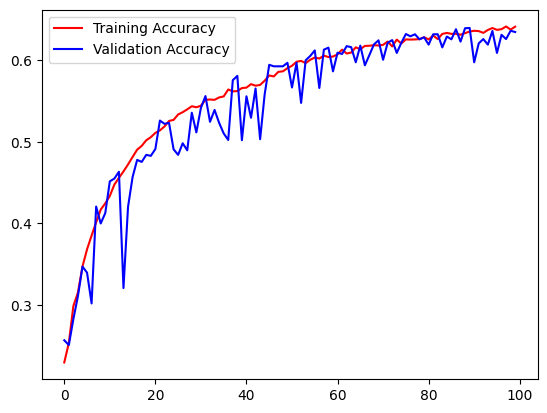

In [130]:
plt.plot(model.history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(model.history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

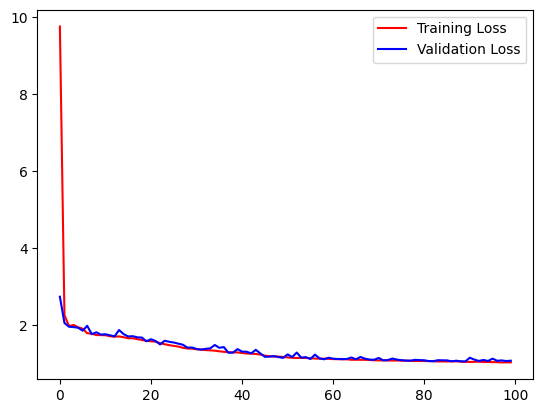

In [131]:
plt.plot(model.history.history["loss"],'r', label="Training Loss")
plt.plot(model.history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

In [132]:
test_loss, test_acc = model.evaluate(X_test, y_test,batch_size=128)

print('Test accuracy:', test_acc)
print('Test loss: ', test_loss)

29/29 [==============================] - 1s 30ms/step - loss: 1.0628 - accuracy: 0.6372
Test accuracy: 0.6372249126434326
Test loss:  1.0627739429473877


In [133]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model and model weights to disk.")

Saved model and model weights to disk.
